In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from PIL import Image
from six.moves import cPickle as pickle
from six.moves import range

image_height = 32
image_width  = 32
num_labels = 11
num_channels = 1 # grayscale

In [2]:
pickle_file = 'svhn_grayscale.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train']
    valid_dataset = save['valid']
    test_dataset = save['test']
    del save  # hint to help gc free up memory

In [3]:
def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_height, image_width, num_channels)).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset['data'], train_dataset['labels'])
valid_dataset, valid_labels = reformat(valid_dataset['data'], valid_dataset['labels'])
test_dataset, test_labels = reformat(test_dataset['data'], test_dataset['labels'])

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (230000, 32, 32, 1) (230000, 6)
Validation set (5754, 32, 32, 1) (5754, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [4]:
import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
for i in range(10):    
    print(train_labels[i])

[ 3  4  6 10 10 10]
[ 4  7  3 10 10 10]
[ 7 10 10 10 10 10]
[ 1  2  5  0 10 10]
[ 4  2  3 10 10 10]
[ 3  1  7 10 10 10]
[ 1  1  5 10 10 10]
[ 7 10 10 10 10 10]
[ 5  9 10 10 10 10]
[ 3 10 10 10 10 10]


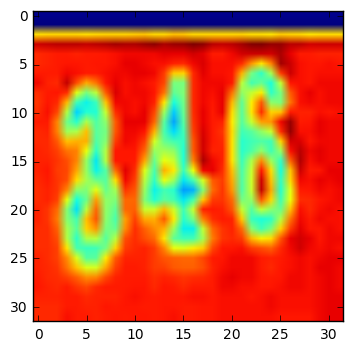

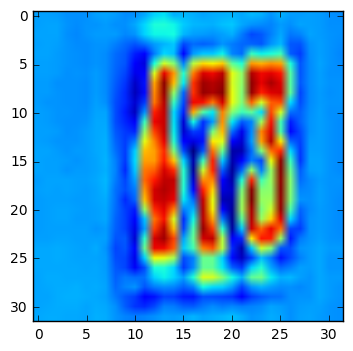

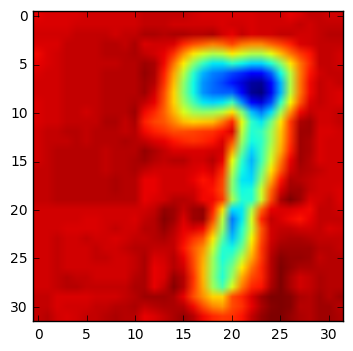

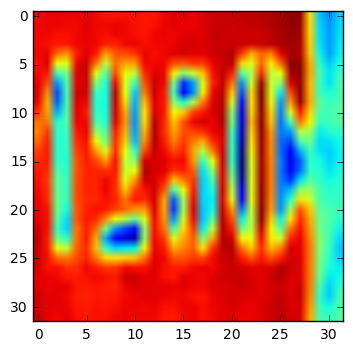

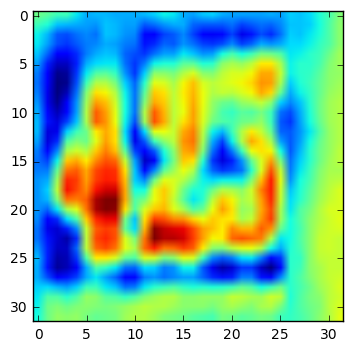

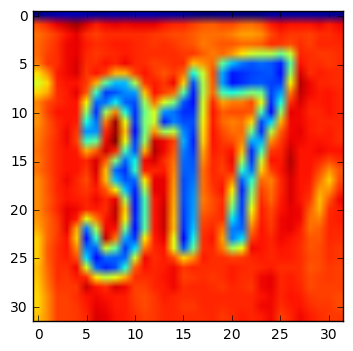

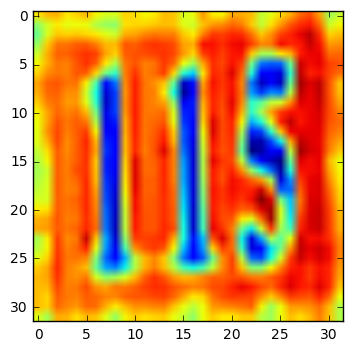

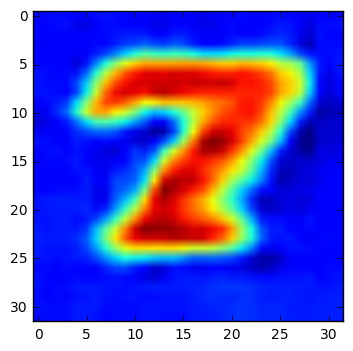

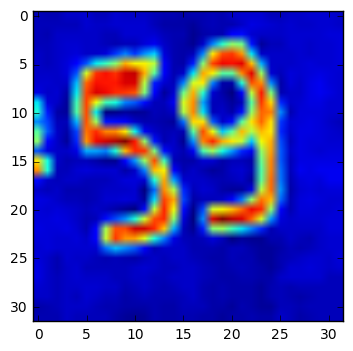

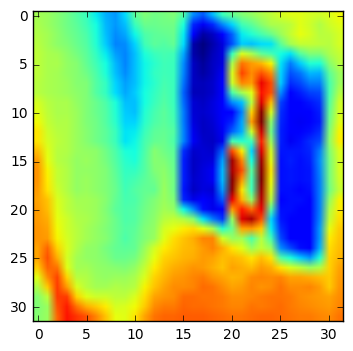

In [5]:
for i in range(10): 
    plt.figure()
    plt.imshow(train_dataset[i,:,:,0])

# Original Setup

In [6]:
def accuracy_digit(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def accuracy_number(predictions, labels):
    return(100.* np.sum(np.all(np.argmax(predictions,2).T == labels, axis=1))/predictions.shape[1])

# Alt. 3

In [50]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 1024
num_channels = 1

graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_height, image_width, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.get_variable('W1', 
            shape=[patch_size, patch_size, num_channels, depth1],
            initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.,shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable('W2', 
            shape=[patch_size, patch_size, depth1, depth2],
            initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.,shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable('W3', 
            shape=[patch_size, patch_size, depth2, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.,shape=[num_hidden]), name='B3')
    
    
    s1_weights = tf.get_variable('S1W1', 
            shape=[num_hidden, num_labels],
            initializer=tf.contrib.layers.xavier_initializer())
    s1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S1B1')
    s2_weights = tf.get_variable('S2W1', 
            shape=[num_hidden, num_labels],
            initializer=tf.contrib.layers.xavier_initializer())
    s2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S2B1')
    s3_weights = tf.get_variable('S3W1', 
            shape=[num_hidden, num_labels],
            initializer=tf.contrib.layers.xavier_initializer())
    s3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S3B1')
    s4_weights = tf.get_variable('S4W1', 
            shape=[num_hidden, num_labels],
            initializer=tf.contrib.layers.xavier_initializer())
    s4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S4B1')
    s5_weights = tf.get_variable('S5W1', 
            shape=[num_hidden, num_labels],
            initializer=tf.contrib.layers.xavier_initializer())
    s5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]),name='S5B1')
    
    # Convolutions
    def conv2d(x, W, b, strides=1):
        conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding='VALID')        
        conv = tf.nn.bias_add(conv,b)
        return tf.nn.relu(conv)

    # Pooling
    def maxpool2d(x, k=2, s=2):
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
    
      # Model: Deep neural network .
    def model(data, keep_prob=1.):
        
        hidden1 = conv2d(data, layer1_weights, layer1_biases)
        hidden1 = tf.nn.local_response_normalization(hidden1)
        hidden1 = maxpool2d(hidden1)
        
        hidden2 = conv2d(hidden1, layer2_weights, layer2_biases)
        hidden2 = tf.nn.local_response_normalization(hidden2)
        hidden2 = maxpool2d(hidden2)
        
        hidden3 = conv2d(hidden2, layer3_weights, layer3_biases)
        hidden3 = tf.nn.dropout(hidden3, keep_prob)
        
        shape = hidden3.get_shape().as_list()
        reshape = tf.reshape(hidden3, [ shape[0], shape[1]*shape[2]*shape[3]])
        
        log1 = tf.matmul(reshape, s1_weights) + s1_biases
        log2 = tf.matmul(reshape, s2_weights) + s2_biases
        log3 = tf.matmul(reshape, s3_weights) + s3_biases
        log4 = tf.matmul(reshape, s4_weights) + s4_biases
        log5 = tf.matmul(reshape, s5_weights) + s5_biases
        
        return log1, log2, log3, log4, log5

    # Training computation.
    logits = model(tf_train_dataset, keep_prob=.85)
    
    # Loss
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:,0])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:,1])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:,2])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:,3])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:,4]))
    
    # Learning rate
#    global_step = tf.Variable(0, name='global_step')
    learning_rate = .01 #.0475
#    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96)
    
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)#,global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(logits[0]),\
                      tf.nn.softmax(logits[1]), tf.nn.softmax(logits[2]),\
                      tf.nn.softmax(logits[3]), tf.nn.softmax(logits[4])])
    
    valid_logits = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]),\
                      tf.nn.softmax(valid_logits[1]), tf.nn.softmax(valid_logits[2]),\
                      tf.nn.softmax(valid_logits[3]), tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]),\
                      tf.nn.softmax(test_logits[1]), tf.nn.softmax(test_logits[2]),\
                      tf.nn.softmax(test_logits[3]), tf.nn.softmax(test_logits[4])])

In [25]:
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch digit accuracy: %.1f%%' % accuracy_digit(predictions, batch_labels[:,0:5]))
            print('Minibatch number accuracy: %.1f%%' % accuracy_number(predictions, batch_labels[:,0:5]))
            valid_pred_eval = valid_prediction.eval()
            print('Validation digit accuracy: %.1f%%' % accuracy_digit(
                    valid_pred_eval, valid_labels[:,0:5]))
            print('Validation number accuracy: %.1f%%' % accuracy_number(
                    valid_pred_eval, valid_labels[:,0:5]))
    test_pred_eval = test_prediction.eval()
    print('Test digit accuracy: %.1f%%' % accuracy_digit(test_pred_eval, test_labels[:,0:5]))
    print('Test number accuracy: %.1f%%' % accuracy_number(test_pred_eval, test_labels[:,0:5]))
    
    # Creates a saver.
    saver0 = tf.train.Saver()
    saver0.save(session, 'saverB-1_30k.ckpt')

Initialized
Minibatch loss at step 0: 20.676516
Minibatch digit accuracy: 6.6%
Minibatch number accuracy: 0.0%
Validation digit accuracy: 51.9%
Validation number accuracy: 0.5%
Minibatch loss at step 500: 7.133049
Minibatch digit accuracy: 53.1%
Minibatch number accuracy: 0.0%
Validation digit accuracy: 55.1%
Validation number accuracy: 0.8%
Minibatch loss at step 1000: 6.150719
Minibatch digit accuracy: 59.4%
Minibatch number accuracy: 4.7%
Validation digit accuracy: 57.1%
Validation number accuracy: 1.7%
Minibatch loss at step 1500: 5.872867
Minibatch digit accuracy: 60.3%
Minibatch number accuracy: 6.2%
Validation digit accuracy: 63.2%
Validation number accuracy: 5.0%
Minibatch loss at step 2000: 4.786001
Minibatch digit accuracy: 70.3%
Minibatch number accuracy: 10.9%
Validation digit accuracy: 70.9%
Validation number accuracy: 16.0%
Minibatch loss at step 2500: 4.146846
Minibatch digit accuracy: 72.5%
Minibatch number accuracy: 18.8%
Validation digit accuracy: 75.6%
Validation num

In [35]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    saver1 = tf.train.Saver()
    saver1.restore(session, 'saverB-1_30k.ckpt')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch digit accuracy: %.1f%%' % accuracy_digit(predictions, batch_labels[:,0:5]))
            print('Minibatch number accuracy: %.1f%%' % accuracy_number(predictions, batch_labels[:,0:5]))
            valid_pred_eval = valid_prediction.eval()
            print('Validation digit accuracy: %.1f%%' % accuracy_digit(
                    valid_pred_eval, valid_labels[:,0:5]))
            print('Validation number accuracy: %.1f%%' % accuracy_number(
                    valid_pred_eval, valid_labels[:,0:5]))
    test_pred_eval = test_prediction.eval()
    print('Test digit accuracy: %.1f%%' % accuracy_digit(test_pred_eval, test_labels[:,0:5]))
    print('Test number accuracy: %.1f%%' % accuracy_number(test_pred_eval, test_labels[:,0:5]))
    
    # Creates a saver.
    saver3 = tf.train.Saver()
    saver3.save(session, 'saverB-1_50k.ckpt')

Minibatch loss at step 0: 1.250331
Minibatch digit accuracy: 92.2%
Minibatch number accuracy: 71.9%
Validation digit accuracy: 89.9%
Validation number accuracy: 66.0%
Minibatch loss at step 500: 1.649492
Minibatch digit accuracy: 91.9%
Minibatch number accuracy: 70.3%
Validation digit accuracy: 89.7%
Validation number accuracy: 65.6%
Minibatch loss at step 1000: 1.310717
Minibatch digit accuracy: 90.9%
Minibatch number accuracy: 64.1%
Validation digit accuracy: 89.7%
Validation number accuracy: 65.0%
Minibatch loss at step 1500: 1.432057
Minibatch digit accuracy: 91.2%
Minibatch number accuracy: 67.2%
Validation digit accuracy: 89.6%
Validation number accuracy: 64.9%
Minibatch loss at step 2000: 1.560004
Minibatch digit accuracy: 92.2%
Minibatch number accuracy: 73.4%
Validation digit accuracy: 89.9%
Validation number accuracy: 66.0%
Minibatch loss at step 2500: 1.482453
Minibatch digit accuracy: 91.2%
Minibatch number accuracy: 75.0%
Validation digit accuracy: 89.8%
Validation number 

In [40]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    saver1 = tf.train.Saver()
    saver1.restore(session, 'saverB-1_50k.ckpt')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch digit accuracy: %.1f%%' % accuracy_digit(predictions, batch_labels[:,0:5]))
            print('Minibatch number accuracy: %.1f%%' % accuracy_number(predictions, batch_labels[:,0:5]))
            valid_pred_eval = valid_prediction.eval()
            print('Validation digit accuracy: %.1f%%' % accuracy_digit(
                    valid_pred_eval, valid_labels[:,0:5]))
            print('Validation number accuracy: %.1f%%' % accuracy_number(
                    valid_pred_eval, valid_labels[:,0:5]))
    test_pred_eval = test_prediction.eval()
    print('Test digit accuracy: %.1f%%' % accuracy_digit(test_pred_eval, test_labels[:,0:5]))
    print('Test number accuracy: %.1f%%' % accuracy_number(test_pred_eval, test_labels[:,0:5]))
    
    # Creates a saver.
    saver3 = tf.train.Saver()
    saver3.save(session, 'saverB-1_70k.ckpt')

Minibatch loss at step 0: 1.167395
Minibatch digit accuracy: 92.8%
Minibatch number accuracy: 78.1%
Validation digit accuracy: 90.4%
Validation number accuracy: 67.3%
Minibatch loss at step 500: 1.563925
Minibatch digit accuracy: 92.5%
Minibatch number accuracy: 68.8%
Validation digit accuracy: 90.6%
Validation number accuracy: 68.1%
Minibatch loss at step 1000: 1.153436
Minibatch digit accuracy: 93.1%
Minibatch number accuracy: 76.6%
Validation digit accuracy: 90.7%
Validation number accuracy: 68.6%
Minibatch loss at step 1500: 1.191306
Minibatch digit accuracy: 92.2%
Minibatch number accuracy: 67.2%
Validation digit accuracy: 90.7%
Validation number accuracy: 68.5%
Minibatch loss at step 2000: 1.180376
Minibatch digit accuracy: 92.8%
Minibatch number accuracy: 70.3%
Validation digit accuracy: 90.6%
Validation number accuracy: 68.3%
Minibatch loss at step 2500: 1.663980
Minibatch digit accuracy: 90.3%
Minibatch number accuracy: 65.6%
Validation digit accuracy: 90.6%
Validation number 

In [47]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    saver1 = tf.train.Saver()
    saver1.restore(session, 'saverB-1_80k.ckpt')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch digit accuracy: %.1f%%' % accuracy_digit(predictions, batch_labels[:,0:5]))
            print('Minibatch number accuracy: %.1f%%' % accuracy_number(predictions, batch_labels[:,0:5]))
            valid_pred_eval = valid_prediction.eval()
            print('Validation digit accuracy: %.1f%%' % accuracy_digit(
                    valid_pred_eval, valid_labels[:,0:5]))
            print('Validation number accuracy: %.1f%%' % accuracy_number(
                    valid_pred_eval, valid_labels[:,0:5]))
    test_pred_eval = test_prediction.eval()
    print('Test digit accuracy: %.1f%%' % accuracy_digit(test_pred_eval, test_labels[:,0:5]))
    print('Test number accuracy: %.1f%%' % accuracy_number(test_pred_eval, test_labels[:,0:5]))
    
    # Creates a saver.
    saver3 = tf.train.Saver()
    saver3.save(session, 'saverB-1_90k.ckpt')

Minibatch loss at step 0: 1.098289
Minibatch digit accuracy: 92.2%
Minibatch number accuracy: 70.3%
Validation digit accuracy: 90.8%
Validation number accuracy: 69.0%
Minibatch loss at step 500: 1.336583
Minibatch digit accuracy: 91.6%
Minibatch number accuracy: 67.2%
Validation digit accuracy: 90.8%
Validation number accuracy: 68.9%
Minibatch loss at step 1000: 1.031218
Minibatch digit accuracy: 93.4%
Minibatch number accuracy: 76.6%
Validation digit accuracy: 90.9%
Validation number accuracy: 69.1%
Minibatch loss at step 1500: 1.125004
Minibatch digit accuracy: 92.2%
Minibatch number accuracy: 70.3%
Validation digit accuracy: 90.9%
Validation number accuracy: 69.1%
Minibatch loss at step 2000: 1.195289
Minibatch digit accuracy: 93.8%
Minibatch number accuracy: 76.6%
Validation digit accuracy: 90.9%
Validation number accuracy: 69.2%
Minibatch loss at step 2500: 1.331446
Minibatch digit accuracy: 91.2%
Minibatch number accuracy: 67.2%
Validation digit accuracy: 90.8%
Validation number 

In [51]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    saver1 = tf.train.Saver()
    saver1.restore(session, 'saverB-1_90k.ckpt')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch digit accuracy: %.1f%%' % accuracy_digit(predictions, batch_labels[:,0:5]))
            print('Minibatch number accuracy: %.1f%%' % accuracy_number(predictions, batch_labels[:,0:5]))
            valid_pred_eval = valid_prediction.eval()
            print('Validation digit accuracy: %.1f%%' % accuracy_digit(
                    valid_pred_eval, valid_labels[:,0:5]))
            print('Validation number accuracy: %.1f%%' % accuracy_number(
                    valid_pred_eval, valid_labels[:,0:5]))
    test_pred_eval = test_prediction.eval()
    print('Test digit accuracy: %.1f%%' % accuracy_digit(test_pred_eval, test_labels[:,0:5]))
    print('Test number accuracy: %.1f%%' % accuracy_number(test_pred_eval, test_labels[:,0:5]))
    
    # Creates a saver.
    saver3 = tf.train.Saver()
    saver3.save(session, 'saverB-1_100k.ckpt')

Minibatch loss at step 0: 1.225515
Minibatch digit accuracy: 91.6%
Minibatch number accuracy: 70.3%
Validation digit accuracy: 90.9%
Validation number accuracy: 69.3%
Minibatch loss at step 500: 1.478122
Minibatch digit accuracy: 91.9%
Minibatch number accuracy: 68.8%
Validation digit accuracy: 90.7%
Validation number accuracy: 68.7%
Minibatch loss at step 1000: 1.015378
Minibatch digit accuracy: 94.4%
Minibatch number accuracy: 81.2%
Validation digit accuracy: 90.8%
Validation number accuracy: 68.8%
Minibatch loss at step 1500: 1.236235
Minibatch digit accuracy: 92.5%
Minibatch number accuracy: 70.3%
Validation digit accuracy: 90.8%
Validation number accuracy: 68.8%
Minibatch loss at step 2000: 1.443449
Minibatch digit accuracy: 91.2%
Minibatch number accuracy: 65.6%
Validation digit accuracy: 90.8%
Validation number accuracy: 69.0%
Minibatch loss at step 2500: 1.415734
Minibatch digit accuracy: 90.9%
Minibatch number accuracy: 68.8%
Validation digit accuracy: 90.7%
Validation number 